A typical NLP pipeline:
1. Data Acquistion
2. Text Cleaning e.g. spell checking with Bing Spell Check REST API and Python https://docs.microsoft.com/en-us/azure/cognitive-services/bing-spell-check/quickstarts/python
3. Pre-Processing e.g. remove special characters & digits, sentence segmentation, word tokenisation, lowercase, stop word removal, stemming, lemmatisation, POS tagging
4. Feature Engineering
5. Modeling
6. Evaluation
7. Deployment
8. Monitoring and Model Updating

In [1]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter
import ast

# Visualisation libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# NLP libraries
from nltk.corpus import stopwords
import nltk
import string
import spacy
sp = spacy.load('en_core_web_sm')

# Machine Learning
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
home_path = os.path.expanduser("~")
plots_fp = '../plots'
os.makedirs(plots_fp, exist_ok=True)
fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text.csv'
df = pd.read_csv(fp)

In [3]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
print(f'Number of documents in dataset: {len(df)}')

Number of documents in dataset: 2225


There are 5 classes in the dataset

In [5]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

The number of examples in each class is:

Checking the proportions of classes is important to observe if there is any class imbalance

,text
category,
business,510
entertainment,386
politics,417
sport,511
tech,401


sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: category, dtype: float64

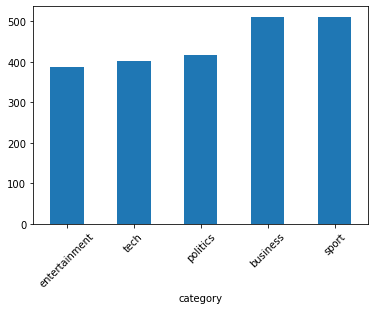

In [6]:
display(df.groupby('category').count())
display(df["category"].value_counts()/df.shape[0]) # Class distribution in the dataset
df.groupby('category').size().sort_values().plot.bar()
plt.xticks(rotation=45);

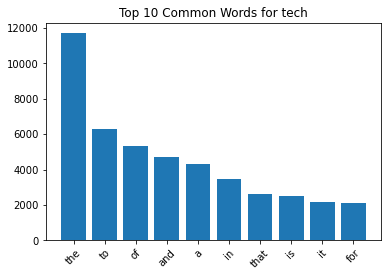

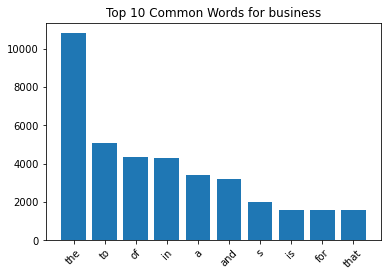

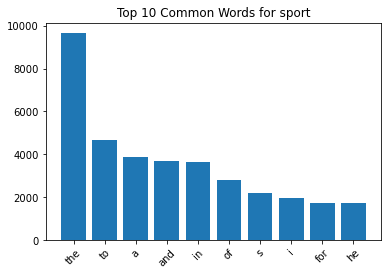

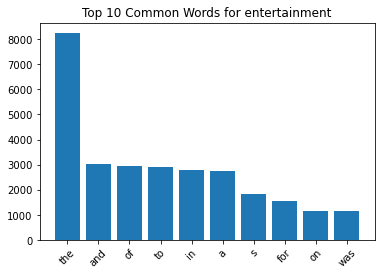

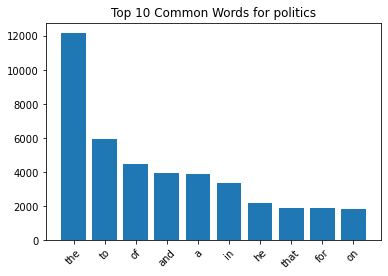

In [7]:
def plot_common_words(text, category):
    text_dict = dict(text)
    plt.bar(text_dict.keys(), text_dict.values())
    plt.title(f'Top 10 Common Words for {category}')
    plt.xticks(rotation=45)
    plt.show()

categories = df.groupby('category')
for category in df.category.unique():
    text = ' '.join(categories.get_group(category)['text'])
    common_words = Counter(text.split()).most_common(10)
    plot_common_words(common_words, category)

Let's look in the politics text to count the punctuation and digits

In [8]:
print(category)
# Are digits/punctuation?
regexp = re.compile('[^a-z A-Z]+') # ^ means not a-z or A-Z or ' ' important to include the space!
punc = [s for t in text for s in t if regexp.search(s)]
print(f'Number of non-character text: {len(punc)}')
Counter(punc)

politics
Number of non-character text: 18894


Counter({'.': 8852,
         '-': 2095,
         '4': 389,
         ':': 675,
         '£': 383,
         '3': 354,
         '5': 503,
         '1': 1027,
         '0': 1974,
         '7': 269,
         '2': 760,
         '6': 271,
         '8': 256,
         '%': 207,
         '9': 456,
         '[': 28,
         ']': 28,
         '(': 110,
         ')': 111,
         ';': 47,
         '$': 12,
         '/': 23,
         '&': 18,
         '#': 7,
         '!': 34,
         '+': 2,
         '=': 2,
         '`': 1})

There is a lot of full stops and numbers. Standard practice is to remove these. 

Note: examples such as “N.Y.” should be treated as a single word and not be tokenized. Such language-specific exceptions can be specified in the tokenizer provided by spaCy. Not implemented here but considered when analysising the results; the decisions we make in preprocessing can have consequences later in the pipeline. 

### Preprocessing
lowercase, remove stopwords, digits and punctunation. Return word tokenised data

In [9]:
def preprocess_corpus(texts):
    mystopwords = set(stopwords.words('english'))
    def remove_stops_digits(tokens):
        return[token.lower() for token in tokens if token not in mystopwords and 
               not token.isdigit() and token not in string.punctuation]
    return remove_stops_digits(nltk.word_tokenize(texts))

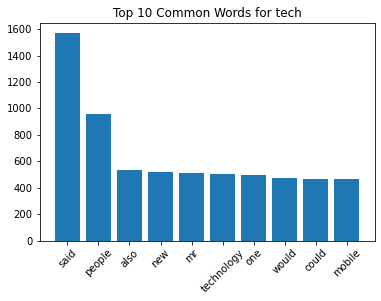

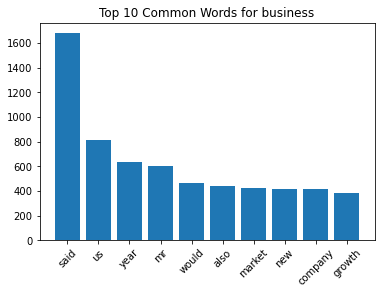

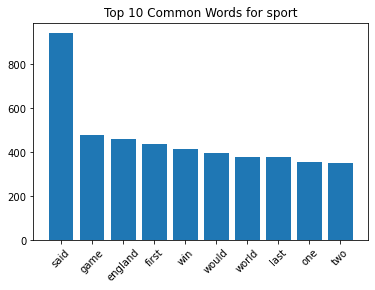

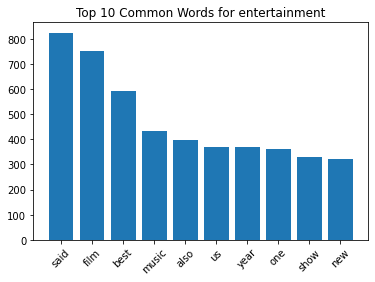

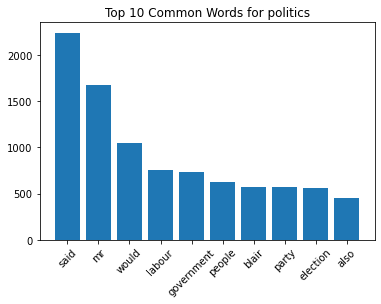

In [10]:
df['prepro'] = df['text'].apply(preprocess_corpus)

categories = df.groupby('category')
for category in df.category.unique():
    text_s = categories.get_group(category)['prepro']  # get the preprocessed data
    corpus = [''.join(j) for i in text_s for j in i]  # join all the tokenised text into one giant list
    common_words = Counter(corpus).most_common(10)  # count the top ten most common words
    plot_common_words(common_words, category)  

Is there any similar words in all 5 classes that we can remove?

Words to be removed: ['said', 'also', 'new', 'one', 'would', 'year']


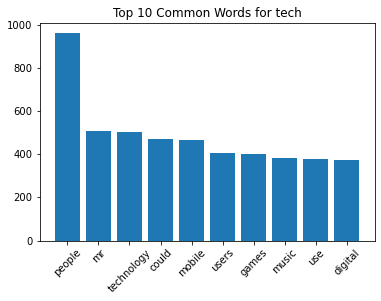

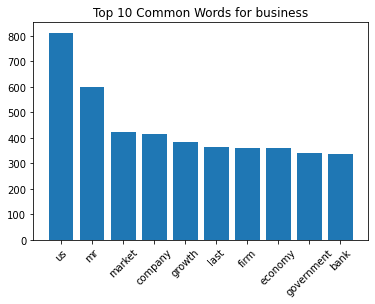

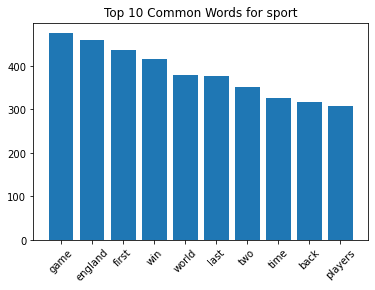

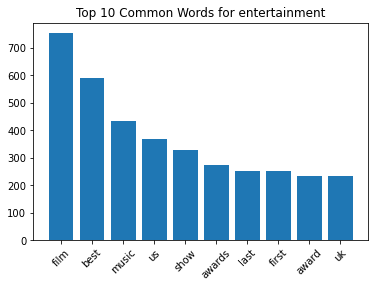

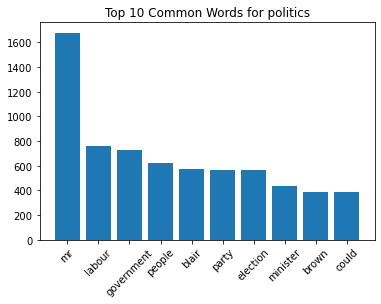

In [11]:
# Get the top common words in each category
all_common = []
for category in df.category.unique():
    text_s = categories.get_group(category)['prepro']  # get the preprocessed data
    corpus = [''.join(j) for i in text_s for j in i]  # join all the tokenised text into one giant list
    common_words = Counter(corpus).most_common(20)
    all_common.append(common_words)
    
# list of lists to one list with word (not counts) returned
flat_list = [item[0] for sublist in all_common for item in sublist]  
# count occurances of top 20 common words in each of the categories
count_d = Counter(flat_list)  
# identify word to remove if it appears in 4 or 5 of the categories 
remove_words = [i[0] for i in count_d.most_common() if i[1] > 3]
print(f'Words to be removed: {remove_words}')

# remove words from the dataset
df['prepro2'] = df['prepro'].apply(lambda x: [item for item in x if item not in remove_words])

# plot results
categories = df.groupby('category')
for category in df.category.unique():
    text_s = categories.get_group(category)['prepro2']  # get the preprocessed data
    corpus = [''.join(j) for i in text_s for j in i]  # join all the tokenised text into one giant list
    common_words = Counter(corpus).most_common(10)  # count the top ten most common words
    plot_common_words(common_words, category)  

Plot wordcloud from the first row of text in the dataframe

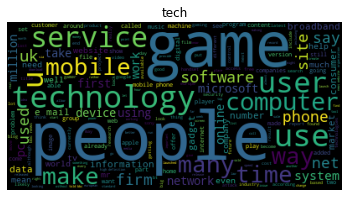

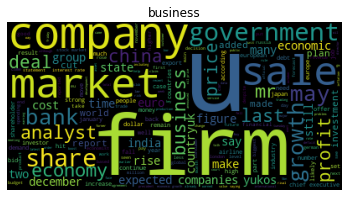

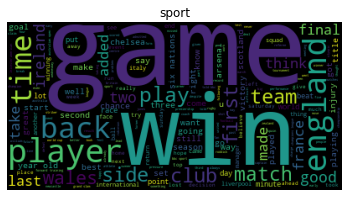

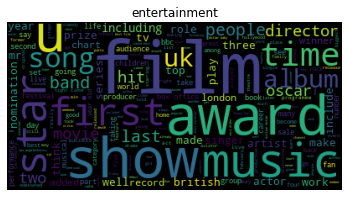

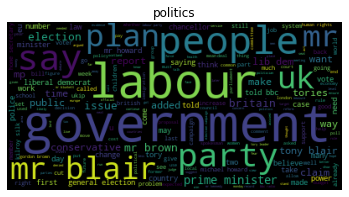

In [12]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.savefig(f'{plots_fp}/{title}.png')
    plt.show()

for category in df.category.unique():
    text_s = categories.get_group(category)['prepro2']
    corpus = ' '.join([' '.join(i) for i in text_s])
    plot_wordcloud(corpus, category)
    

#### Stemming and Lemmatisation

Examples of lemmatisation

In [13]:
for word in df['prepro2'].iloc[0]:
    token = sp(word)
    for w in token:
        if w.text != w.lemma_:
            print(w.text, w.lemma_)

hands hand
viewers viewer
systems system
tvs tv
recorders recorder
moving move
living live
years year
according accord
gathered gather
electronics electronic
technologies technology
pastimes pastime
us we
leading lead
programmes programme
delivered deliver
viewers viewer
networks network
telecoms telecom
companies company
providers provider
rooms room
devices device
talked talk
technologies technology
ces ce
recorders recorder
boxes box
us we
programmes programme
allows allow
personalised personalise
built build
sets set
us we
slower slow
adverts advert
abiding abide
schedules schedule
putting put
us we
networks network
companies company
means mean
terms term
revenues revenue
viewer view
channels channel
us we
leads lead
raised raise
growing grow
services service
happens happen
months month
years year
told tell
likes like
issues issue
lost lose
pressing press
broadcasters broadcaster
talking talk
brands brand
brands brand
communications communication
connections connection
added add
me

#### Lemmatisation

Lemmatisation takes words such as e-mail and anti-something and split them up. 

In order to change that behaviour we have to remove the '-'

In [14]:
df['prepro3'] = df['prepro2'].apply(lambda row: [word.replace('-', '') for word in row])

Because lemmatisation takes about 30minutes I can check to see if the saved dataset already exists on my laptop. If it does then I use that, else, run lemmatisation. 

Note: Pandas saves column lists as strings. To keep the objects I should save as pickles in the future. 

In [15]:
%%time
df_preprop_fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text-preprocessed.csv'
if not os.path.exists(df_preprop_fp):
    # lemmatisation
    df['prepro4'] = df['prepro3'].apply(lambda row: [w.lemma_ for i in row for w in sp(i)])
    # data formatting
    df= df.drop(['text', 'prepro', 'prepro2','prepro3'], axis=1)
    df = df.rename(columns={'prepro4':'text'})
    # save dataframe
    df.to_csv(df_preprop_fp, index=False)
else: #load preprocessed(lemmatisated) dataframe
    df = pd.read_csv(df_preprop_fp)
    
df.head()

CPU times: user 30.4 ms, sys: 7.61 ms, total: 38 ms
Wall time: 36.7 ms


,category,text
0,tech,"['tv', 'future', 'hand', 'viewer', 'home', 'th..."
1,business,"['worldcom', 'boss', 'leave', 'book', 'alone',..."
2,sport,"['tiger', 'wary', 'farrell', 'gamble', 'leices..."
3,sport,"['yeade', 'face', 'newcastle', 'fa', 'cup', 'p..."
4,entertainment,"['ocean', 'twelve', 'raid', 'box', 'office', '..."


# Baseline model. 

Something really simply... top words?

First we split the data into training and testing

In [43]:
train, test = train_test_split(df, test_size=0.25, random_state=42)
len(train), len(test)

(1668, 557)

Create a lookup table of the most common words in the trainig data texts for each category

In [67]:
lookup = {}
categories = train.groupby('category')
for category in train.category.unique():
    text_s = categories.get_group(category)['text']
    true = categories.get_group(category)['category']
    corpus = [''.join(j) for i in text_s for j in ast.literal_eval(i)]  # join all the tokenised text into one giant list
    common_words = dict(Counter(corpus).most_common(5))
    lookup[true.iloc[0]] = list(common_words.keys())
print(lookup)

{'business': ['we', 'company', 'market', 'firm', 'mr'], 'entertainment': ['film', 'good', 'award', 'music', 'show'], 'sport': ['game', 'play', 'win', 'go', 'get'], 'politics': ['mr', 'labour', 'government', 'party', 'say'], 'tech': ['use', 'people', 'technology', 'game', 'make']}


Does each doument contain at least one of these words?

In [78]:
%%time 
def rules_based_lookup_nlp(df:object, lookup_dict:dict):
    preds = []
    for index, row in df.iterrows():
        doc = ast.literal_eval(row['text'])
        words_in_doc_count = 0
        d_freq = {}
        for k, v in lookup_dict.items():
            for word in v:
                count = doc.count(word)
                words_in_doc_count += count
            frequency = words_in_doc_count/len(doc)
            d_freq[k] = frequency
        pred = max(d_freq, key=d_freq.get)
        preds.append(pred)
    return preds


preds = rules_based_lookup_nlp(train, lookup)
print(f"Train Accuracy: {accuracy_score(y_true=list(train['category']), y_pred=preds)}")
print(Counter(preds))
preds = rules_based_lookup_nlp(test, lookup)
print(f"Test Accuracy: {accuracy_score(y_true=list(test['category']), y_pred=preds)}")
print(Counter(preds))

Train Accuracy: 0.25539568345323743
Counter({'tech': 1306, 'politics': 163, 'sport': 118, 'entertainment': 43, 'business': 38})
Test Accuracy: 0.2710951526032316
Counter({'tech': 433, 'politics': 55, 'sport': 42, 'entertainment': 14, 'business': 13})
CPU times: user 904 ms, sys: 9.72 ms, total: 913 ms
Wall time: 931 ms


A low score of about 25% train dataset and 27% test dataset.  

Perhaps the lookup common words could be improved i.e.remove verbs, punctuation, pronouns.

For this I use spaCy's part-of-speech (POS) tagging to identify the words to remove:

In [79]:
categories = train.groupby('category')
to_remove = []
for category in train.category.unique():
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(' '.join(lookup[category]))
    for token in doc:
        if token.pos_ == 'VERB' or token.pos == 'X' or token.pos_== 'PUNCT' or token.pos_ == 'PRON':
            to_remove.append(token.text)

lookup_v2 = {i: [val for val in j if val not in to_remove] for i, j in lookup.items()}
print(lookup_v2)

{'business': ['market', 'firm', 'mr'], 'entertainment': ['film', 'good', 'award', 'music', 'show'], 'sport': ['game', 'play', 'win'], 'politics': ['mr', 'labour', 'government', 'party'], 'tech': ['people', 'technology', 'game']}


In [80]:
%%time 
preds = rules_based_lookup_nlp(train, lookup_v2)
print(f"Train Accuracy: {accuracy_score(y_true=list(train['category']), y_pred=preds)}")
print(Counter(preds))
preds = rules_based_lookup_nlp(test, lookup_v2)
print(f"Test Accuracy: {accuracy_score(y_true=list(test['category']), y_pred=preds)}")
print(Counter(preds))

Train Accuracy: 0.3776978417266187
Counter({'tech': 905, 'politics': 324, 'sport': 173, 'entertainment': 137, 'business': 129})
Test Accuracy: 0.4111310592459605
Counter({'tech': 271, 'politics': 113, 'sport': 68, 'business': 56, 'entertainment': 49})
CPU times: user 887 ms, sys: 9.88 ms, total: 897 ms
Wall time: 900 ms


Things learned with rule-based NLP:
- the accuracy was lower with more common words for each category; tested 20, 10 then 5 words. Therefore 5 common words per category seemed to work best
- some punctuation such as £ and single letters snuck through the data preprocessing step
- removing common words e.g. verbs such as go, get, make, improved the result
- there are a lot of similar common words e.g. mr, game

### TF-IDF
Term Frequency — Inverse Document Frequency

"This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining" (source: https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089)

Term Frequency: measures the frequency of a word in a document:

`TF(t,d) = (Number of occurances of term t in document d) / (Total number of terms in the document d)`

Inverse Document Frequency (IDF) measure the importance of the term across a corpus:

`IDF(t) = loge (Total number of documents in the corpus) / (Number of documents with term t in them)`

Sometimes in IDF equation we +1 to the denomiator to avoid zero division. 